In [108]:
import pandas as pd
import os
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
import math

In [109]:

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()


In [4]:
'''
from mpl_toolkits.mplot3d import Axes3D
#%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'
%matplotlib inline
'''

## noisy sinus example

In [12]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [13]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)


## Use own data

In [50]:
# use own data

data_df = pd.read_csv("country_indicators.csv",dtype={"Country Name": str, "Indicator Name": str, "Year": int, "Value": float})
indicators = data_df.groupby(['Country Name', 'Year'])['Indicator Name'].apply(lambda x: list(np.unique(x)))[0]
indicator_pairs = list(itertools.combinations(indicators, 2))
processed_df = data_df.groupby(['Country Name', 'Year', 'Indicator Name'])['Value'].aggregate('mean').unstack().reset_index()


In [74]:
'''
entry 0: ('Agriculture, value added (% of GDP)', 'CO2 emissions (metric tons per capita)')
entry 17: ('CO2 emissions (metric tons per capita)', 'Fertility rate, total (births per woman)')
'''
ind_pair = indicator_pairs[0]
print(ind_pair)

('Agriculture, value added (% of GDP)', 'CO2 emissions (metric tons per capita)')


In [75]:

# may only use data of one year
yearly_processed_dfs_dict = {}
for year in set(data_df["Year"]):
    yearly_processed_dfs_dict[year] = processed_df.loc[processed_df["Year"]==year]

# use all years
plot_df = processed_df[[ind_pair[0], ind_pair[1]]].dropna()
# use one specific year
plot_df = yearly_processed_dfs_dict[2007][[ind_pair[0], ind_pair[1]]].dropna()


observation_index_points_ = np.array(plot_df[ind_pair[0]]).reshape(-1,1)
observations_ = np.array(plot_df[ind_pair[1]])

In [77]:
init_amplitude = 7.
init_length_scale = 10.

In [78]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  # MaternOneHalf = Laplace kernel = A*exp(-|x-y|/l)
  # kernel = tfk.MaternOneHalf(amplitude, length_scale)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=init_amplitude, scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=init_length_scale, scale=np.float64(5.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})


In [79]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))


sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=1.1284709107461697>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=5782.815050316184>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=798.277186333188>, 'observations': <tf.Tensor: shape=(225,), dtype=float64, numpy=
array([-1131.04113587, -1130.43182718, -1131.80027699, -1133.97362601,
       -1133.09972942, -1133.39711761, -1132.83861496, -1130.13742636,
       -1134.43900498, -1134.0938763 , -1132.50541213, -1133.34484687,
       -1130.86861882, -1129.78675244, -1131.77955021, -1133.72994578,
       -1132.30818566, -1131.79301438, -1129.80566807, -1132.59102325,
       -1130.64937564, -1132.66798631, -1132.65839742, -1132.57273077,
       -1131.31465563, -1133.70368716, -1132.56328593, -1129.62308834,
       -1127.25531411, -1131.95547078, -1127.88236711, -1130.89441181,
       -1132.63186687, -1131.71843609, -1132.25820855, -1125.3534819 ,
       -1130.31937863, -1123.98506845, -

In [80]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=init_amplitude,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=init_length_scale,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]


In [81]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })


In [84]:
# Now we optimize the model parameters.
num_iters = 600
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))


Trained parameters:
amplitude: 41.66054655395596
length_scale: 16.601060921642137
observation_noise_variance: 17.488394432720696


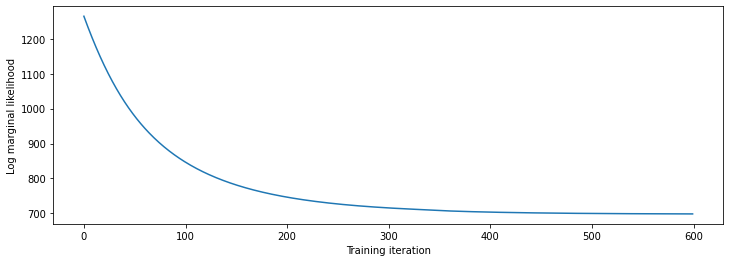

In [85]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()


In [86]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

#optimized_kernel = tfk.MaternOneHalf(amplitude_var, length_scale_var)
optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  20 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 20
samples = gprm.sample(num_samples)


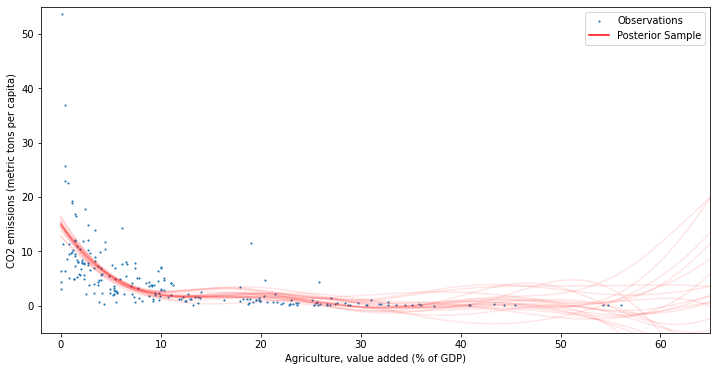

In [96]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 6))
#plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
#         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations', s=1.2#[abs(math.log(n+0.001)) for n in observation_index_points_[:, 0]]
           )
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(ind_pair[0])
plt.ylabel(ind_pair[1])
plt.xlim(-2,65)
plt.ylim(-5,55)
plt.show()


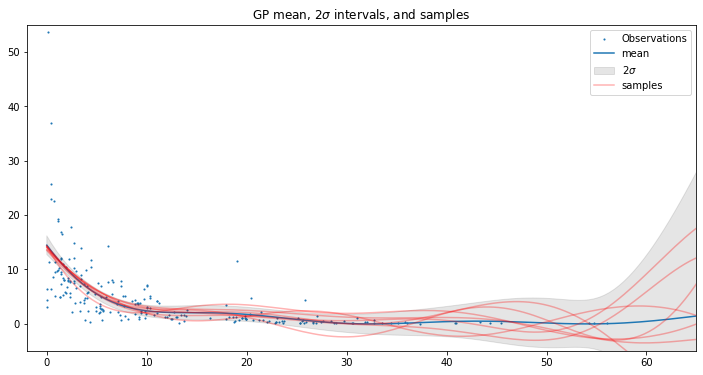

In [97]:

plt.figure(figsize=(12, 6))
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations', s=1.2#[abs(math.log(n)) for n in observation_index_points_[:, 0]]
           )

upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.plot(predictive_index_points_[:, 0], gprm.mean(), label="mean")
plt.fill_between(predictive_index_points_[:, 0], upper, lower, color='k', alpha=.1, label="$2\sigma$")
for i in range(7):
    if i == 0:
        plt.plot(predictive_index_points_[:, 0], gprm.sample(), c='r', alpha=.3, label="samples")
    else:
        plt.plot(predictive_index_points_[:, 0], gprm.sample(), c='r', alpha=.3)
plt.title(r"GP mean, $2\sigma$ intervals, and samples")
plt.legend()
plt.xlim(-2,65)
plt.ylim(-5,55)
plt.show()


## Marginalizing hyperparameters with HMC

In [101]:
num_results = 10
num_burnin_steps = 70

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]


In [102]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))


Inference ran in 6.23s.


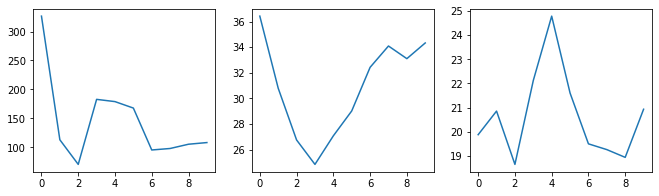

In [103]:
(amplitude_samples,
 length_scale_samples,
 observation_noise_variance_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
  ax = f.add_subplot(1, len(samples) + 1, i + 1)
  ax.plot(s)


In [104]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
#batch_of_posterior_kernels = tfk.MaternOneHalf(amplitude_samples, length_scale_samples)
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(amplitude_samples, length_scale_samples)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 20
samples = predictive_gprm.sample(num_samples)


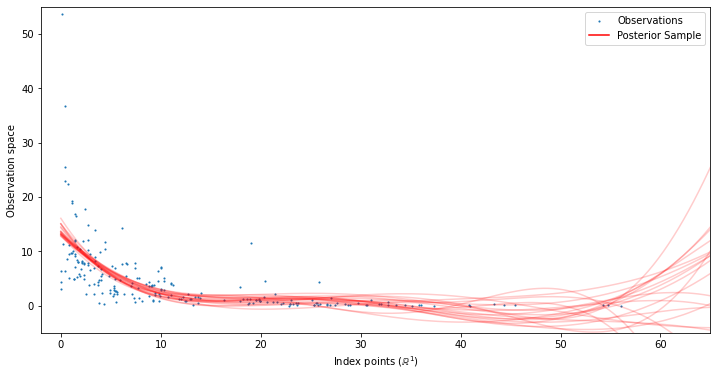

In [107]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 6))
#plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
#         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations', s=1.2#[abs(math.log(n)) for n in observation_index_points_[:, 0]]
           )
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.2,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.xlim(-2,65)
plt.ylim(-5,55)
plt.show()
